# Synthetic experiments 

Using synthetic DGPs for DRCT, we produce DOBS using Algorithm 2 from Gentzel et al. (2021) and
separately via our RCT rejection sampler.

In [1]:
from causal_eval.sampling import *

import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2 

In [2]:
# random seed for the sampling methods same throughout
rng = np.random.default_rng(10)

### Synthetic DGP Setting #1 
`|C| = 1, P (T = 1) = 0.3`

In [19]:
data, rct_ace = synthetic_dgp(setting=1, num_samples=100000)

Sanity check
RCT ACE unadjusted:  2.4809951502961516
RCT ACE adjusting for C parametric backdoor:  2.4864917936261794


In [20]:
# Use the same parameters for the researcher-specified confouding functions for both sampling approaches
confound_func_params={"para_form": "linear"} 

In the cell below, we calculate the absolute bias (abs. bias) between ATE from DRCT and the estimated ATE via backdoor adjustment on DOBS created by each sampling algorithm. We also report abs. bias relative to the RCT ATE
(rel. abs. bias) and the mean and standard deviation (std.) across samples from 1000 random seeds.

#### Confidence Intervals 

We can construct confidence intervals via bootstrapping. We follow these steps: 

1. Use sampling (RCT rejection or Gentzel) to create data sample $S$
2. Bootstrapping: resample $S$ with replacement $b$ times. 
3. Calculate the ACE for each bootstrap sample. 
4. Use the percentile method to obtain 95% confidence intervals. 

In [21]:
data_out1 = bootstrapping_three_methods_linear(data, rct_ace, confound_func_params)

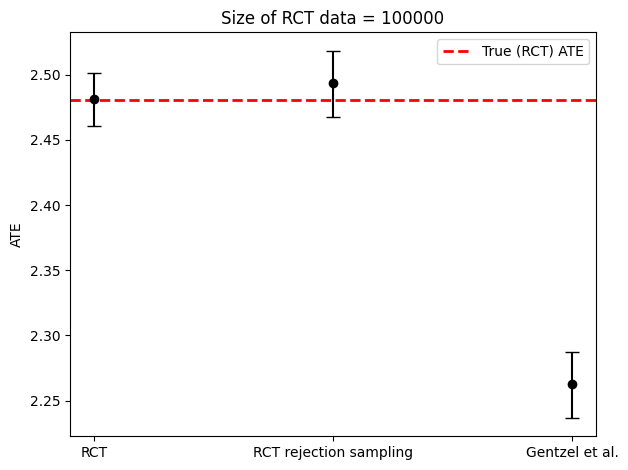

In [22]:
#title = f"Synthetic DGP #1 \nSize of RCT data = {len(data)} \n1000 Bootstrap samples"
title = f"Size of RCT data = {len(data)}"
fig, ax = plot_bootstrap(data_out1, rct_ace, title);
fig.savefig(f"syn1-ci-{len(data)}.png")

We'll do the same thing with a smaller number of original samples. 

In [23]:
data, rct_ace = synthetic_dgp(setting=1, num_samples=3000)

Sanity check
RCT ACE unadjusted:  2.541418640823207
RCT ACE adjusting for C parametric backdoor:  2.5318633267482284


In [24]:
data_out2 = bootstrapping_three_methods_linear(data, rct_ace, confound_func_params)

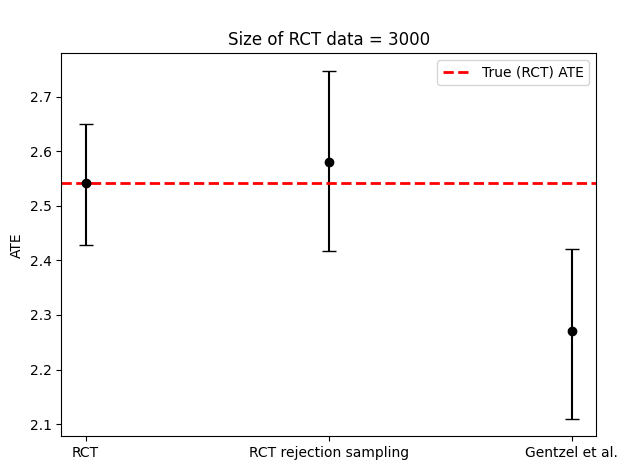

In [25]:
#title = f"Synthetic DGP #1 \nSize of RCT data = {len(data)} \n1000 Bootstrap samples"
title =  f"\nSize of RCT data = {len(data)}"
fig, ax = plot_bootstrap(data_out2, rct_ace, title);
fig.savefig(f"syn1-ci-{len(data)}.png")

Now, run through many seeds and get the results for the table. 

In [ ]:
data, rct_ace = synthetic_dgp(setting=1, num_samples=1000)

In [ ]:
out =  many_seeds(data, rct_ace, confound_func_params, is_linear=True, num_seeds=10, 
                  has_bootstrap=True, 
                  num_bootstrap_samples=1000)

In [ ]:
results =  many_seeds(data, rct_ace, confound_func_params, is_linear=True, num_seeds=10, 
                  has_bootstrap=True, 
                  num_bootstrap_samples=1000, num_cores=10,
                  run_in_parallel=True)

### Synthetic DGP Setting #2 
`|C| = 1, P (T = 1) = 0.5 `

In [ ]:
data, rct_ace = synthetic_dgp(setting=2, num_samples=100000)

The cell below gives the results for the two different sampling algorithms for the synthetic DGP setting in the cell above across 1000 random seeds. 

In [ ]:
confound_func_params={"para_form": "linear"} 
out =  many_seeds(data, rct_ace, confound_func_params, is_linear=True, num_seeds=1000, 
                  has_bootstrap=True, 
                  num_bootstrap_samples=1000)

### Synthetic DGP Setting #3 
`|C| = 5, Nonlinear`

In [ ]:
data, rct_ace = synthetic_dgp(setting=3, num_samples=100000)

The cell below gives the results for the two different sampling algorithms for the synthetic DGP setting in the cell above across 1000 random seeds. 

In [ ]:
confound_func_params = {"para_form": "nonlinear", "C1": 1.5, "C2": -0.7, "C3": 1.2, "C4": 1.5, "C5": -1.2}

out =  many_seeds(data, rct_ace, confound_func_params, 
                  is_linear=False, 
                  num_seeds=1000, 
                  has_bootstrap=True, 
                  num_bootstrap_samples=1000)